In [25]:
import numpy as np
import re
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import Dense, LSTM, Input, Dropout, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras

In [26]:
# детерминация случайных величин, отвечающих за выбор первоначальных весов и биасов
tf.compat.v1.set_random_seed(290)
tf.random.set_seed(290)
np.random.seed(400)

In [27]:
#///////////////////////////////// для колбэков

    # для Early_stopping
ES_patience = 20 # кол-во эпох без улучшений
ES_min_delta = 0.001 # минимальное улучшение параметра за cur_patience
ES_monitor_parametr =  'loss' # отслеживаемый параметр 
ES_save_best_weights = True # сохранять ли веса нейронки с лучшими результатами
    
    # для ReduceLROnPlateau
RLPOP_monitor_parametr = 'val_loss'  # отслеживаемый параметр 
RLPOP_factor = 0.1 # множитель для расчета нового шага сходимости (new_learning_rate = old_learning_rate*RLPOP_factor)
RLPOP_patience = 10 # кол-во эпох без улучшений
RLPOP_verbose = 1 # выводить ли прогресс изменения шага сходимости в его процессее
RLPOP_mode = 'auto' # выбирает, уменьшать шаг сходимости при росте величины или при её уменьшении
RLPOP_min_delta = 0.0001 # порог изменения отслеживаемого значения
RLPOP_cooldown = 0 # количество эпох до возобновления работы после изменения шага сходимости
RLPOP_min_lr = 0 # минимальное значение шага сходимости

    # для CallbackList
CBL_add_history = True # вызывать ли колбэк History (если он не был довавлен вручную)
CBL_add_progbar = True # вызывать ли колбэк ProgbarLogger (если он не был довавлен вручную)
    
maxWordsCount = 1000
max_text_len = 10
FIT_batch_size = 10 #8 #15

In [28]:
# разделить данные на тренировочные и тестовые
def split(X,Y,factor):
    X_train=X[:factor]
    Y_train=Y[:factor]
    X_test=X[factor:]
    Y_test=Y[factor:]
    return X_train,Y_train,X_test,Y_test

In [29]:
with open('train_data_true', 'r', encoding='utf-8') as f:
    texts_true = f.readlines()
    texts_true[0] = texts_true[0].replace('\ufeff', '') #убираем первый невидимый символ

with open('train_data_false', 'r', encoding='utf-8') as f:
    texts_false = f.readlines()
    texts_false[0] = texts_false[0].replace('\ufeff', '') #убираем первый невидимый символ

In [30]:
texts = texts_true + texts_false
count_true = len(texts_true)
count_false = len(texts_false)
total_lines = count_true + count_false
print(count_true, count_false, total_lines)

print("texts_true", type(texts_true))

print("pos_text", texts_true[:10])
print("neg_text", texts_false[:10])

84 88 172
texts_true <class 'list'>
pos_text ['Думайте позитивно и верьте в свою способность достигать отличных результатов. \n', 'Вы — лучший ответ на проблемы, которые возникли в понедельник.\n', 'Если вы смогли в понедельник подняться с постели, значит вы супер герой. \n', 'Твои утренние мысли в понедельник задают тон всей твоей неделе. \n', 'Живи так чтобы увидеть, как ты становишься сильнее и живешь счастливой, полноценной жизнью.\n', 'Не позволяйте утренним проблемам помешать вам быть успешным.\n', 'Тяжелые времена часто приводят к величайшим моментам вашей жизни.\n', 'Продолжайте двигаться. Трудности в конце концов создают сильных людей.\n', 'Независимо через что вы проходите, в конце туннеля есть свет. Может показаться, что добраться до него сложно, но вы сможете сделать это.\n', 'Чем больше вы настроены позитивно и говорите: я хочу иметь хорошую жизнь, тем больше вы строите для себя эту реальность\n']
neg_text ['Я притягиваю только плохое\n', 'Кому я нужен с такой внешностью\n

In [31]:
X_data = np.array(texts)

Y_data = np.array([1]*count_true + [0]*count_false)
print(X_data.shape, Y_data.shape)

indeces = np.random.choice(X_data.shape[0], size = X_data.shape[0], replace=False)
#print(indeces)
X_data = X_data[indeces]
Y_data = Y_data[indeces]

factor = int(.80 * X_data.shape[0])

X_train,Y_train,X_test,Y_test = split(X_data,Y_data,factor)

print("train: ", X_train.shape, Y_train.shape, type(X_train), type(Y_train))
print("test: ", X_test.shape, Y_test.shape, type(X_test), type(Y_test))

print("train: ", X_train[0])

print("train: ", X_test[0])

(172,) (172,)
train:  (137,) (137,) <class 'numpy.ndarray'> <class 'numpy.ndarray'>
test:  (35,) (35,) <class 'numpy.ndarray'> <class 'numpy.ndarray'>
train:  Выбор позитивного настроя и благодарного отношения определит, как вы собираетесь прожить свою жизнь.

train:  Вы уникальны! У вас разные таланты и способности. Вам не нужно всегда идти по стопам других.



In [33]:
#print(X.shape)
#LSTM?
#Sequential.compile?
#equential.fit?

In [34]:
#Sequential model с преобработкой
#tf.keras.layers.experimental.preprocessing.TextVectorization?

vectproc = tf.keras.layers.experimental.preprocessing.TextVectorization( #tf.keras.layers.TextVectorization(
    max_tokens = maxWordsCount, 
    standardize = 'lower_and_strip_punctuation',
    split = 'whitespace',
    output_mode = 'int',
    output_sequence_length = max_text_len,
    )

text_dataset = tf.data.Dataset.from_tensor_slices(texts)

vectproc.adapt(text_dataset.batch(64))

model = tf.keras.models.Sequential()

model.add(Input(shape=(1,), dtype=tf.string))
model.add(vectproc)
model.add(Embedding(maxWordsCount, output_dim = 128, input_length = max_text_len))
#model.add(LSTM(units = 128, return_sequences = True, dropout = 0.3))
#model.add(LSTM(units = 64, dropout = 0.3))
model.add(LSTM(units = 64, return_sequences = True, dropout = 0.3))
model.add(LSTM(units = 16, dropout = 0.3))
model.add(Dense(units = 1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_1 (TextVe (None, 10)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 10, 128)           128000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 64)            49408     
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                5184      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 182,609
Trainable params: 182,609
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Создание и настройка колбэков
callback_list = [] # массив колбэков до подачи в колбек "callbacklist"

temp = keras.callbacks.EarlyStopping(
            monitor = ES_monitor_parametr, 
            min_delta = ES_min_delta, 
            patience = ES_patience,
            restore_best_weights = ES_save_best_weights
            )
callback_list.append(temp)

temp = keras.callbacks.ReduceLROnPlateau(
            monitor = RLPOP_monitor_parametr, 
            factor = RLPOP_factor, 
            patience = RLPOP_patience, 
            verbose = RLPOP_verbose,
            mode = RLPOP_mode, 
            min_delta = RLPOP_min_delta, 
            cooldown = RLPOP_cooldown, 
            min_lr = RLPOP_min_lr
            )
callback_list.append(temp)

FIT_callback_list = keras.callbacks.CallbackList(
            callbacks = callback_list, 
            add_history = CBL_add_history, 
            add_progbar = CBL_add_progbar, 
            model = model
            )

In [11]:
model.compile(loss = 'binary_crossentropy',#'mean_squared_error', 
              metrics=['accuracy'], 
              # learning_rate = 0.1
              optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01))
#tf.keras.optimizers.SGD(learning_rate = 0.01)) #0.01
# tf.keras.optimizers.SGD(learning_rate = 0.0001)) #0.05)) #Adam(0.0003)) #'categorical_crossentropy'

In [12]:
history = model.fit(X_train, 
                    Y_train, 
                    batch_size = FIT_batch_size, 
                    shuffle = True, 
                    verbose = 1, 
                    epochs = 10, #250, #30, 
                    validation_split = 0.20,
                    callbacks = FIT_callback_list)

11/11 [==============================] - 0s 4ms/step - loss: 0.6883 - accuracy: 0.5780 - val_loss: 0.6922 - val_accuracy: 0.5357


In [13]:
#Sequential.fit?

In [14]:
#reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

In [21]:
#t = "негативы".lower()
#data = tokenizer.texts_to_sequences([t])
#print(data)
#data_pad = pad_sequences(data, maxlen=max_text_len)
#print( sequence_to_text(data[0]) )
#print(X_test)
for x in range(1): #range(len(X_test)): 
    #print(f"X_test[{x}]: ", X_test[x], "X_test type: ", type(X_test[x]))
    
    a = np.array([X_test[x]]) 
    #print(f"a: ", a, "a type", type(a))
    print(a)
    res = model.predict(a)
        
    mark = "Положительно" if np.mean(res) > 0.5 else "Отрицательно"
    mark2 = "Положительно" if Y_test[x] == 1 else "Отрицательно"
    equal = "==" if mark == mark2 else "  "
    #print((f"Maybe[{mark}] [%.4f] " % np.mean(res)) + equal + f" Right[{mark2}]\t" + 
    #      ' '.join(list(filter(None, sequence_to_text(X_test[x])))) )
    print((f"Maybe[{mark}] [%.4f] " % np.mean(res)) + equal + f" Right[{mark2}]\t" + X_test[x])
    
    #print(res)
        #print("res: ", res )
        #print("Положительно" if np.argmax(res) == 1 else "отрицательно")
    

['Вы уникальны! У вас разные таланты и способности. Вам не нужно всегда идти по стопам других.\n']
Maybe[Положительно] [0.5112] == Right[Положительно]	Вы уникальны! У вас разные таланты и способности. Вам не нужно всегда идти по стопам других.



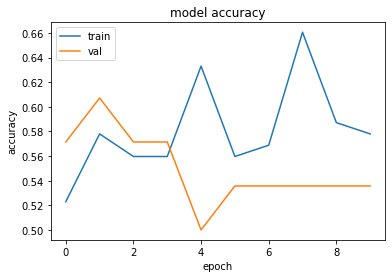

In [16]:
# Вывод графика изменения ошибки
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

In [17]:
# тест модели
model.evaluate(X_test, Y_test, batch_size = FIT_batch_size)

4/4 [==============================] - 0s 750us/step - loss: 0.6871 - accuracy: 0.5714


[0.6870793700218201, 0.5714285969734192]

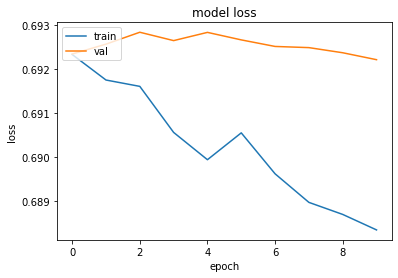

In [18]:
# Вывод графика изменения ошибки
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

In [19]:
t = "если вы просто посмотрите на жизнь позитивно произойдут позитивные вещи"

a = list()
a.append(t)

#res = model.predict(data_pad)
res = model.predict(a)

mark = "Положительно" if np.mean(res) > 0.5 else "отрицательно"

print(f"mark [{mark}]")
print("res: ", res)
print("res[0,0]: ", res[0,0])

mark [Положительно]
res:  [[0.5125662]]
res[0,0]:  0.5125662


In [20]:
t = "это просто ужасно плохо противно не хорошо"

a = list()
a.append(t)

print(a)
#res = model.predict(data_pad)
res = model.predict(a)

mark = "Положительно" if np.mean(res) > 0.5 else "отрицательно"

print(f"mark [{mark}]")
print("res: ", res)
print("res[0,0]: ", res[0,0])

['это просто ужасно плохо противно не хорошо']
mark [Положительно]
res:  [[0.50313413]]
res[0,0]:  0.50313413
